In [2]:
import os
import socket
import random
import keras2onnx

import numpy as np
import tensorflow as tf
from keras.layers import *

# RULE SPEC
BOARD_SIZE = 12
ACTIONS = 30
FACTIONS = 3  # FACTION_1, FACTION_2, NEUTRAL (ELEMENT)
IS_CONTROLLED = 1
ATTRIBUTES = 5
STATUES = 9  # should be an encoded process set?

# MODEL SPEC
CONV_FILTERS = 48
KERNEL = 3
NUM_RES_BLOCKS = 3
DROPOUT_RATE = 0.3

# DATA SPEC
SAMPLES_PER_GAME = 5

AttributeError: module 'tensorflow.python.keras' has no attribute 'applications'

2024-04-06 22:55:59.028842: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 22:55:59.053377: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 22:55:59.053445: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 22:55:59.055814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 22:55:59.055868: I tensorflow/compile

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 board_input (InputLayer)       [(None, 2592)]       0           []                               
                                                                                                  
 reshape (Reshape)              (None, 12, 12, 18)   0           ['board_input[0][0]']            
                                                                                                  
 conv2d (Conv2D)                (None, 12, 12, 48)   7776        ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 12, 12, 48)  192         ['conv2d[0][0]']                 
 alization)                                                                                   

r/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 22:55:59.580424: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 22:55:59.580496: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:08:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-04-06 22:55:59.580505: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1722] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
2024-04-06 22:55:59.580547: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to r

                                                                                                  
 conv2d_8 (Conv2D)              (None, 12, 12, 48)   2304        ['re_lu_9[0][0]']                
                                                                                                  
 re_lu_10 (ReLU)                (None, 12, 12, 1)    0           ['batch_normalization_7[0][0]']  
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 12, 12, 48)  192         ['conv2d_8[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 flatten (Flatten)              (None, 144)          0           ['re_lu_10[0][0]']               
                                                                                                  
 re_lu_12 

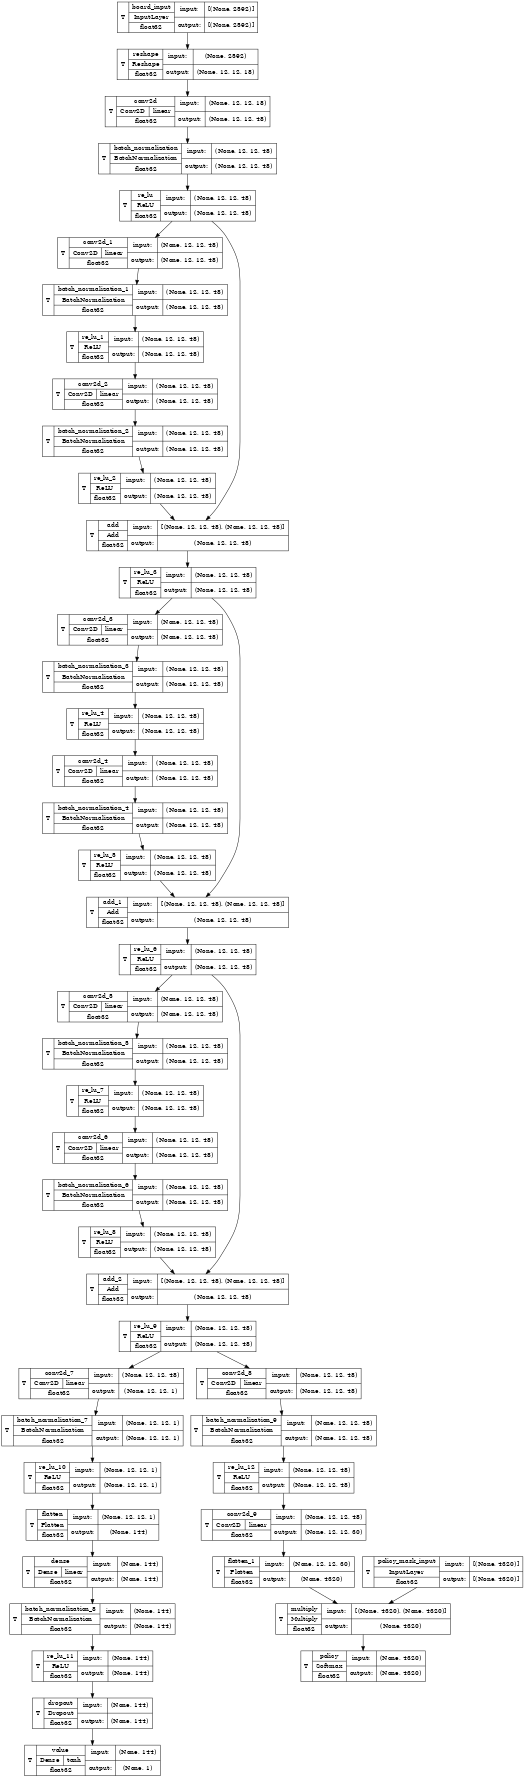

In [2]:
def res_block(y):
    r = Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', use_bias=False)(y)
    r = BatchNormalization()(r)
    r = ReLU()(r)
    r = Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', use_bias=False)(r)
    r = BatchNormalization()(r)
    r = ReLU()(r)
    r = Add()([r, y])
    r = ReLU()(r)
    return r


def build_model():
    board_input_layer = Input(name="board_input",
                              shape=(BOARD_SIZE * BOARD_SIZE * (FACTIONS + IS_CONTROLLED + ATTRIBUTES + STATUES)))
    policy_mask_input = Input(name="policy_mask_input", shape=(BOARD_SIZE * BOARD_SIZE * ACTIONS))

    x = Reshape(target_shape=(BOARD_SIZE, BOARD_SIZE, FACTIONS + IS_CONTROLLED + ATTRIBUTES + STATUES))(
        board_input_layer)
    x = Conv2D(filters=CONV_FILTERS, kernel_size=KERNEL, strides=1, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    for _ in range(NUM_RES_BLOCKS):
        x = res_block(x)

    # value head
    vx = Conv2D(filters=1, kernel_size=1, padding='same', use_bias=False)(x)
    vx = BatchNormalization()(vx)
    vx = ReLU()(vx)
    vx = Flatten()(vx)
    vx = Dense(BOARD_SIZE * BOARD_SIZE, use_bias=False)(vx)
    vx = BatchNormalization()(vx)
    vx = ReLU()(vx)
    vx = Dropout(DROPOUT_RATE)(vx)
    vx = Dense(1, activation='tanh', name='value')(vx)
    value_output_layer = vx

    # policy head
    px = Conv2D(filters=CONV_FILTERS, kernel_size=1, padding='same', use_bias=False)(x)
    px = BatchNormalization()(px)
    px = ReLU()(px)
    px = Conv2D(filters=ACTIONS, kernel_size=1, padding='same', use_bias=True)(px)
    px = Flatten()(px)
    px = Multiply()([px, policy_mask_input])
    px = Softmax(name='policy')(px)
    policy_output_layer = px  # TODO mask them before softmax?

    return tf.keras.models.Model(inputs=[board_input_layer, policy_mask_input], outputs=[policy_output_layer, value_output_layer])


model = build_model()
model.compile(loss=['categorical_crossentropy', 'mean_squared_error'], optimizer='adam', metrics=['accuracy'])
model.summary()

tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=32,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)


In [3]:
model.save("./player_zero_model_gen0/")

2024-04-06 22:56:55.501705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'board_input' with dtype float and shape [?,2592]
	 [[{{node board_input}}]]
2024-04-06 22:56:55.636769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'board_input' with dtype float and shape [?,2592]
	 [[{{node board_input}}]]
2024-04-06 22:56:55.692342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,2592]
	 [[{{node inpu

INFO:tensorflow:Assets written to: ./player_zero_model_gen0/assets


INFO:tensorflow:Assets written to: ./player_zero_model_gen0/assets


In [2]:
SERVER_ADDRESS = "127.0.0.1"
SERVER_PORT = 22442

SIGNAL_SELF_PLAY_START = b"SPS"
SIGNAL_SELF_PLAY_END = b"SPE"
SIGNAL_NN_TRAINING_START = b"NTS"
SIGNAL_NN_TRAINING_END = b"NTE"
SIGNAL_END_OF_STREAM = b"EOS"

server_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
server_socket.bind((SERVER_ADDRESS, SERVER_PORT))
server_socket.listen()

print("Server is listening on {}:{}".format(SERVER_ADDRESS, SERVER_PORT))

# accept a connection
# wait for training command
# train
# send training completed
# if end command received: stop connection.

while True:
    client_socket, client_address = server_socket.accept()
    print("Connection accepted from:", client_address)

    try:
        # Send SERVER_HELLO to client
        client_socket.sendall(SIGNAL_SELF_PLAY_END)

        while True:
            # Receive data from client
            data = client_socket.recv(1024)
            if not data:
                break

            print("Received from client:", data.decode())

            # Send HANDSHAKE_COMPLETE to client
            client_socket.sendall(SIGNAL_END_OF_STREAM)

    finally:
        print("Closing connection with:", client_address)
        client_socket.close()
        break

Server is listening on 127.0.0.1:22442
Connection accepted from: ('127.0.0.1', 52946)
Received from client: HI
Closing connection with: ('127.0.0.1', 52946)
Connection accepted from: ('127.0.0.1', 54242)
Received from client: HI
Closing connection with: ('127.0.0.1', 54242)


KeyboardInterrupt: 

In [105]:

def load_sel_play_data(filepath: str):
    game_board_list = []
    game_policy_mask_list = []
    game_policy_list = []
    game_turn_factions = []

    winner: float
    with open(filepath, 'r') as f:
        while True:
            board = np.zeros(shape=(2592,), dtype=float)
            # BOARD_SIZE * BOARD_SIZE * (FACTIONS + IS_CONTROLLED + ATTRIBUTES + STATUES))
            policy = np.zeros(shape=(4320,), dtype=float)
            policy_mask = np.zeros(shape=(4320,), dtype=float)
            # BOARD_SIZE * BOARD_SIZE * ACTION
            current_faction = None

            num_units = int(f.readline())
            for _ in range(num_units):
                element_data = np.fromstring(f.readline(), dtype=float, sep=',')
                element_index = round(element_data[0] * BOARD_SIZE + element_data[1]) * 18
                board[element_index: element_index + len(element_data) - 2] = element_data[2:]

                if element_data[5] == 1.0:
                    current_faction = 1.0 if element_data[3] == 1.0 else -1.0

            num_actions = int(f.readline())
            for _ in range(num_actions):
                action_data = np.fromstring(f.readline(), dtype=float, sep=',')
                action_index = round(action_data[0] * BOARD_SIZE + action_data[1]) * ACTIONS + round(action_data[2])
                policy[action_index] = action_data[4]
                policy_mask[action_index] = 1.0

            if num_actions == num_units == 0:
                winner = float(f.readline())
                break

            game_board_list.append(board)
            game_policy_mask_list.append(policy_mask)
            game_policy_list.append(policy)
            game_turn_factions.append(current_faction)

    game_iterator = zip(game_board_list, game_policy_mask_list, game_policy_list, game_turn_factions) \
        if len(game_turn_factions) <= SAMPLES_PER_GAME \
        else random.sample(list(zip(game_board_list, game_policy_mask_list, game_policy_list, game_turn_factions)), k=SAMPLES_PER_GAME)

    for board, policy_mask, policy, turn_faction in game_iterator:
        if turn_faction is None:
            print("No current unit on board?")

        board_list.append(board)
        policy_mask_list.append(policy_mask)
        policy_list.append(policy)
        value_list.append(turn_faction * winner)


# X Data loader for single file finished,
# X create data loading for all files
# X select random X samples from each file
# X add to one dataset
# X train on said dataset (training pipeline)
# tie communication

board_list = []
policy_mask_list = []
policy_list = []
value_list = []

for file in os.listdir("../gaf6/generated/"):
    if file.startswith("sim_"):
        load_sel_play_data("../gaf6/generated/" + file)

board_stack = np.vstack(board_list)
policy_mask_stack = np.vstack(policy_mask_list)
policy_stack = np.vstack(policy_list)
value_stack = np.vstack(value_list)

print(f"{board_stack.shape=}")
print(f"{policy_mask_stack.shape=}")
print(f"{policy_stack.shape=}")
print(f"{value_stack.shape=}")

board_stack.shape=(25, 2592)
policy_mask_stack.shape=(25, 4320)
policy_stack.shape=(25, 4320)
value_stack.shape=(25, 1)


In [106]:
_history = model.fit(
    x=[board_stack, policy_mask_stack],
    y=[policy_stack, value_stack],
    batch_size=32,
    epochs=100,
)


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 17.9758 - policy_loss: 16.8811 - value_loss: 1.0947 - policy_accuracy: 0.2000 - value_accuracy: 0.0400
Epoch 2/100
1/1 [==============================] - 0s 53ms/step - loss: 10.8067 - policy_loss: 9.8807 - value_loss: 0.9260 - policy_accuracy: 0.1600 - value_accuracy: 0.2000
Epoch 3/100
1/1 [==============================] - 0s 51ms/step - loss: 9.0952 - policy_loss: 8.7955 - value_loss: 0.2998 - policy_accuracy: 0.2000 - value_accuracy: 0.3200
Epoch 4/100
1/1 [==============================] - 0s 51ms/step - loss: 8.6482 - policy_loss: 8.5151 - value_loss: 0.1331 - policy_accuracy: 0.2400 - value_accuracy: 0.4800
Epoch 5/100
1/1 [==============================] - 0s 52ms/step - loss: 8.3554 - policy_loss: 8.2874 - value_loss: 0.0680 - policy_accuracy: 0.2400 - value_accuracy: 0.4000
Epoch 6/100
1/1 [==============================] - 0s 52ms/step - loss: 8.2342 - policy_loss: 8.0687 - value_loss: 0.1656 - policy_acc